# Kalman Filter

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg as la
from scipy.stats import multivariate_normal as mvn

plt.style.use("seaborn-v0_8")

In [13]:
# Parameters for 1D motion dynamics
dt = 1.
R_var = 1
Q_var = 0.1

x_init = [0., 15.]
x = np.array(x_init).reshape(2, 1)
A = np.array([[1., dt], [0, 1.]])
C = np.array([[1., 0]])
P = np.diag([0.5, 0.1])  # covariance matrix for the state estimate
Q = np.diag([Q_var, Q_var])  # covariance matrix for the process disturbance
R = np.array([[R_var]])  # covariance matrix for the measurement noise

In [14]:
# Generate the ground truth 1D motion and noisy measurements 
num_iter = 20


def generate_1d_motion(x: np.ndarray, A: np.ndarray, count) -> (np.ndarray, np.ndarray):
    xs = [x]
    for i in range(count):
        x = A @ x
        xs.append(x)

    return np.array(xs)


def generate_1d_measurement(x: np.ndarray, C: np.ndarray, R: np.ndarray) -> (np.ndarray, np.ndarray):
    ys = []
    for i in range(x.shape[0]):
        y = C @ x[i, :]
        r, c = y.shape
        y += mvn.rvs(mean=np.zeros(r), cov=R, size=1)
        ys.append(y.reshape(r, ))

    return np.array(ys)


xs = generate_1d_motion(x, A, num_iter)
ys = generate_1d_measurement(xs, C, R)


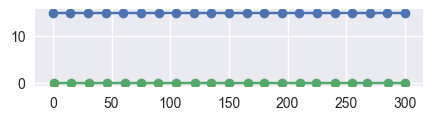

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 1))
ax.plot(xs[:, 0], xs[:, 1], 'o-')
ax.plot(ys, np.zeros_like(ys), 'o-')
plt.show()

## Prediction only

In [16]:
# Prediction only
N = 100

x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)

x_pred = np.zeros((num_iter + 1, N, 2))
x_pred[0, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

for i in range(num_iter):
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    x_pred[i + 1, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

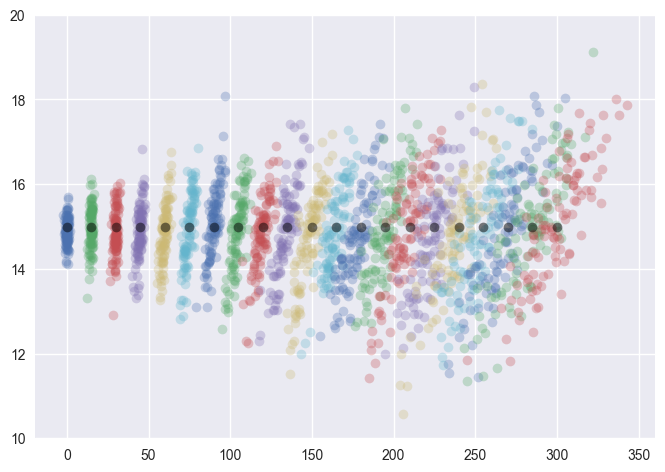

In [17]:
fig, ax = plt.subplots()

for z in range(num_iter + 1):
    ax.plot(x_pred[z, :, 0], x_pred[z, :, 1], 'o', alpha=0.3)

ax.plot(xs[:, 0], xs[:, 1], 'o', color='k', alpha=0.5)
ax.set_ylim(10, 20)

plt.show()

## Prediction and measurement update

In [18]:
# Define a number of iterations and an array to store the state estimates
N = 100
x_meas = np.zeros((num_iter + 1, N, 2))

# Initial noisy estimate and measurement
x_hat = np.array(x_init).reshape(2, 1)
x_hat += mvn.rvs(mean=np.zeros(2), cov=P, size=1).reshape(2, 1)


def kalman_gain(P: np.ndarray, C: np.ndarray, R: np.ndarray) -> np.ndarray:
    """Calculate the Kalman gain."""
    S = C @ P @ C.T + R
    K = P @ C.T @ la.inv(S)
    return K


K = kalman_gain(P, C, R)
x_hat = x_hat + K @ (ys[0] - C @ x_hat)
P = P - K @ C @ P

x_meas[0, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

print(x_hat)
# [[ 0.46355285]
#  [15.3781233 ]]

[[ 0.84810627]
 [15.72071934]]


In [19]:
# Iterative prediction and measurement update
for i in range(num_iter):
    # prediction
    x_hat = A @ x_hat
    P = A @ P @ A.T + Q

    # measurement update    
    K = kalman_gain(P, C, R)
    x_hat = x_hat + K @ (ys[i + 1] - C @ x_hat)
    P = P - K @ C @ P

    x_meas[i + 1, :, :] = mvn.rvs(mean=x_hat.reshape(2, ), cov=P, size=N)

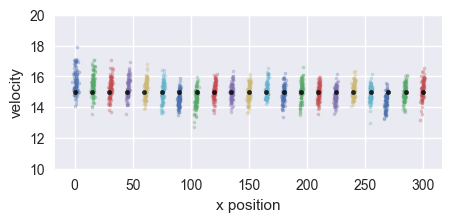

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2))

for i in range(num_iter + 1):
    # Scatter plot
    ax.scatter(x_meas[i, :, 0], x_meas[i, :, 1], s=5, alpha=0.3)

# Plot the ground truth
ax.scatter(xs[:, 0], xs[:, 1], s=10, color='k', alpha=0.8)
ax.set_ylim(10, 20)
ax.set_xlabel('x position')
ax.set_ylabel('velocity')

plt.show()

In [11]:
x_meas[i, :, 0]

array([299.53923138, 300.11501794, 300.16742247, 300.8501833 ,
       297.92277544, 300.02234342, 299.32257785, 297.8361286 ,
       298.87290943, 300.29997682, 299.19098554, 300.69431466,
       300.32547537, 298.9894621 , 298.47310496, 299.6722607 ,
       301.98082548, 300.24789325, 299.8255962 , 299.06020736,
       299.27012514, 300.56625368, 298.68954609, 299.71372857,
       298.40713301, 300.61196274, 298.96951532, 300.18659684,
       300.03617679, 298.96711561, 299.7951467 , 300.87672659,
       299.14852098, 299.36814728, 299.81232853, 298.8408451 ,
       299.71583614, 300.54777427, 300.68600853, 300.53561485,
       299.9086636 , 300.18539632, 299.35426077, 300.47635946,
       299.33132988, 299.6988879 , 299.82234928, 300.07645445,
       300.25992639, 298.38992254, 299.42257199, 299.71473948,
       300.60865368, 300.54697438, 300.02466636, 300.34197512,
       299.53546932, 300.2828915 , 300.72909501, 300.81496302,
       301.03014162, 301.70121625, 299.47580596, 299.41